In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import time

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import classification_report, make_scorer, fbeta_score
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale, StandardScaler, PolynomialFeatures

# настройки dask
# import dask
# import dask.dataframe as dd
# from dask.distributed import Client
# from dask_ml.model_selection import train_test_split, GridSearchCV
# from dask_ml.preprocessing import StandardScaler, PolynomialFeatures
# dask.config.set({'distributed.scheduler.worker-saturation': 1.0})
# client = Client()

%matplotlib inline
#warnings.filterwarnings("ignore")


Загрузим данные.
Файл слишком большой для того, чтобы его можно было скачать с гуглодиска по прямой ссылке: выдаёт сообщение о невозможности проверить на вирусы.

In [ ]:

# загрузим данные
#url='https://drive.google.com/uc?id=1ktY9vvtX_fheGE7lou7ZOfi8aiXHjOvk'
#df = pd.read_csv(url, compression='zip', sep=',')

df = pd.read_csv("creditcard.csv.zip")
#df = dd.from_pandas(df, npartitions=4)
#url='https://drive.google.com/file/d/1PmfTN46BcIEtCfV29gMZ1pPldQB5dQUQ/view?usp=sharing'
#url='https://drive.google.com/file/d/1ktY9vvtX_fheGE7lou7ZOfi8aiXHjOvk/view?usp=sharing'
#url='https://drive.google.com/uc?id=' + url.split('/')[-2]
#df = pd.read_csv(url)


df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Пропуски в данных отсутствуют

In [ ]:
print(df['Class'].value_counts())
print(df['Time'].value_counts())
print('Time min = ', df['Time'].min(), 'Time max = ', df['Time'].max())

0    284315
1       492
Name: Class, dtype: int64
163152.0    36
64947.0     26
68780.0     25
3767.0      21
3770.0      20
            ..
127750.0     1
62260.0      1
62259.0      1
127753.0     1
172792.0     1
Name: Time, Length: 124592, dtype: int64
Time min =  0.0 Time max =  172792.0


В прочитанном файле большая часть колонок содержит данные в формате float64, но судя по количеству знаков после запятой, такая точность -- избыточна.

In [ ]:
# некоторые инструменты неспособны работать с датасетами, содержащими целочисленные
# и нецелые данные, поэтому приводим всё к np.float32
# а вообще, идея была хорошая
# specific_types = {'Time': np.int32, 'Class': np.int32}
# df = df.astype(
#     {column_name: specific_types.get(column_name, np.float32) for column_name in df.columns}
# )
df = df.astype({column_name: np.float32 for column_name in df.columns})
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

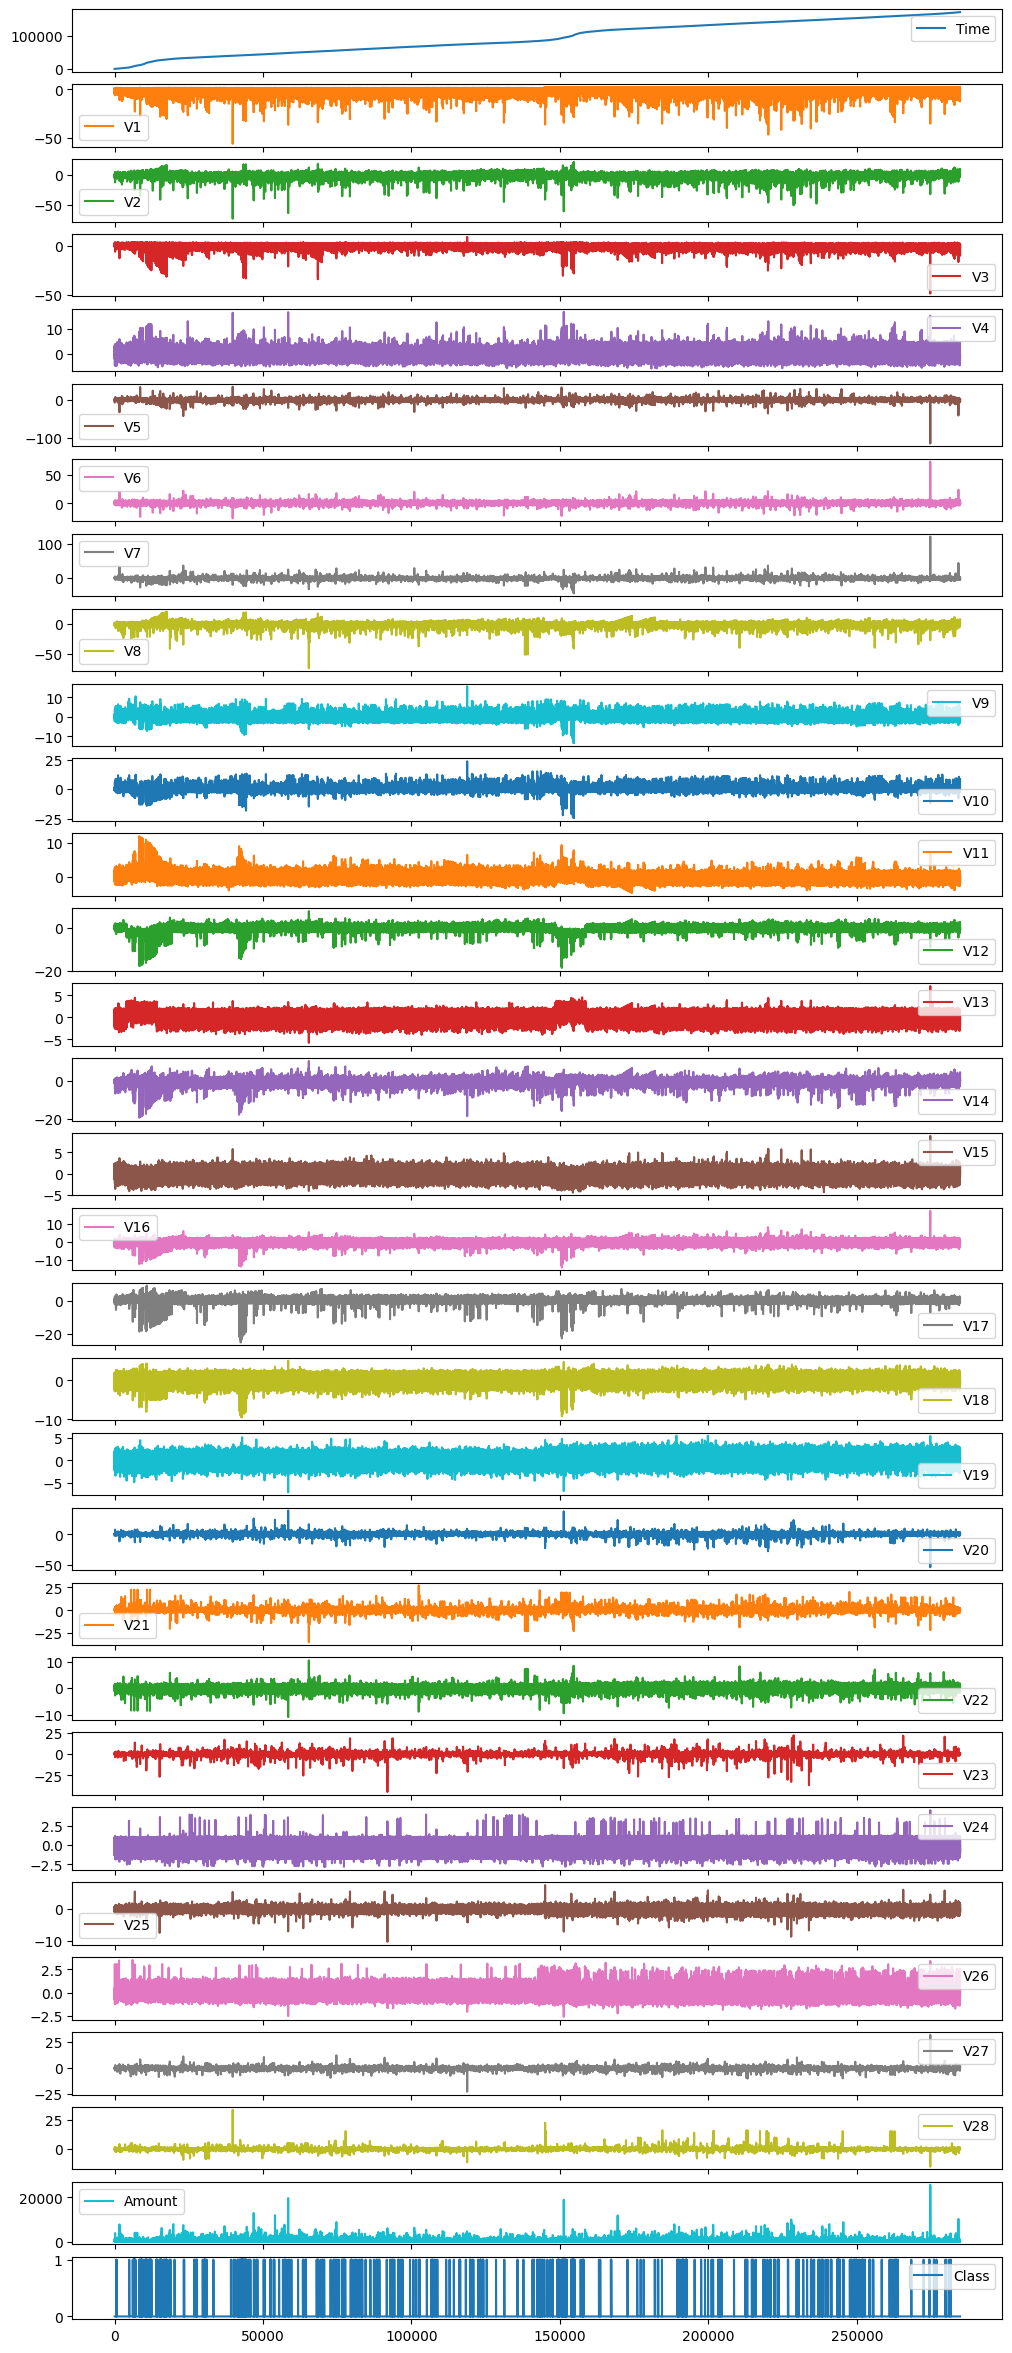

In [ ]:
df.plot(subplots=True, figsize = (12, 30))

Судя по графикам, выбросы есть и их не так уж мало. Выкидывать вручную не хочется, так что попробуем воспользоваться автоматическими средствами.

Поле Time, из общих соображений, не должно влиять навероятность, того, что трансакция -- мошенническая.

Поле Class также нет смысла учитывать при поиске выбросов.

In [ ]:
data = df.drop(columns=['Time', 'Class'])

In [ ]:
# %%time
# clf = LocalOutlierFactor()
# lof_results=clf.fit_predict(data),
# np.unique(lof_results, return_counts=True)

(array([-1,  1]), array([ 12467, 272340]))

Данный метод позволяет найти некоторое количество выбросов, но работает довольно медленно (порядка 9 минут).

In [ ]:
#df1 = df1.assign(if_outliers=pd.Series(np.random.randn(sLength)).values)
#data = data.assign(if_inliers=if_results)
#data = data.assign(Class=df['Class'])
#data.loc[data['if_inliers']==-1]['Class'].value_counts()

In [ ]:
clf = IsolationForest()
if_results=clf.fit_predict(data)
np.unique(if_results, return_counts=True)

CPU times: user 7.47 s, sys: 131 ms, total: 7.6 s
Wall time: 7.63 s


(array([-1,  1]), array([ 11835, 272972]))

Очистим данные, удалив то, что удалось определить, как выбросы.
Элементы искомого класса (Class = 1) выбросами не считаются

In [ ]:
data = data.assign(if_inliers=if_results)
data = data.assign(Class=df['Class'])
data.loc[data['if_inliers']==-1]['Class'].value_counts()


0.0    11434
1.0      401
Name: Class, dtype: int64

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

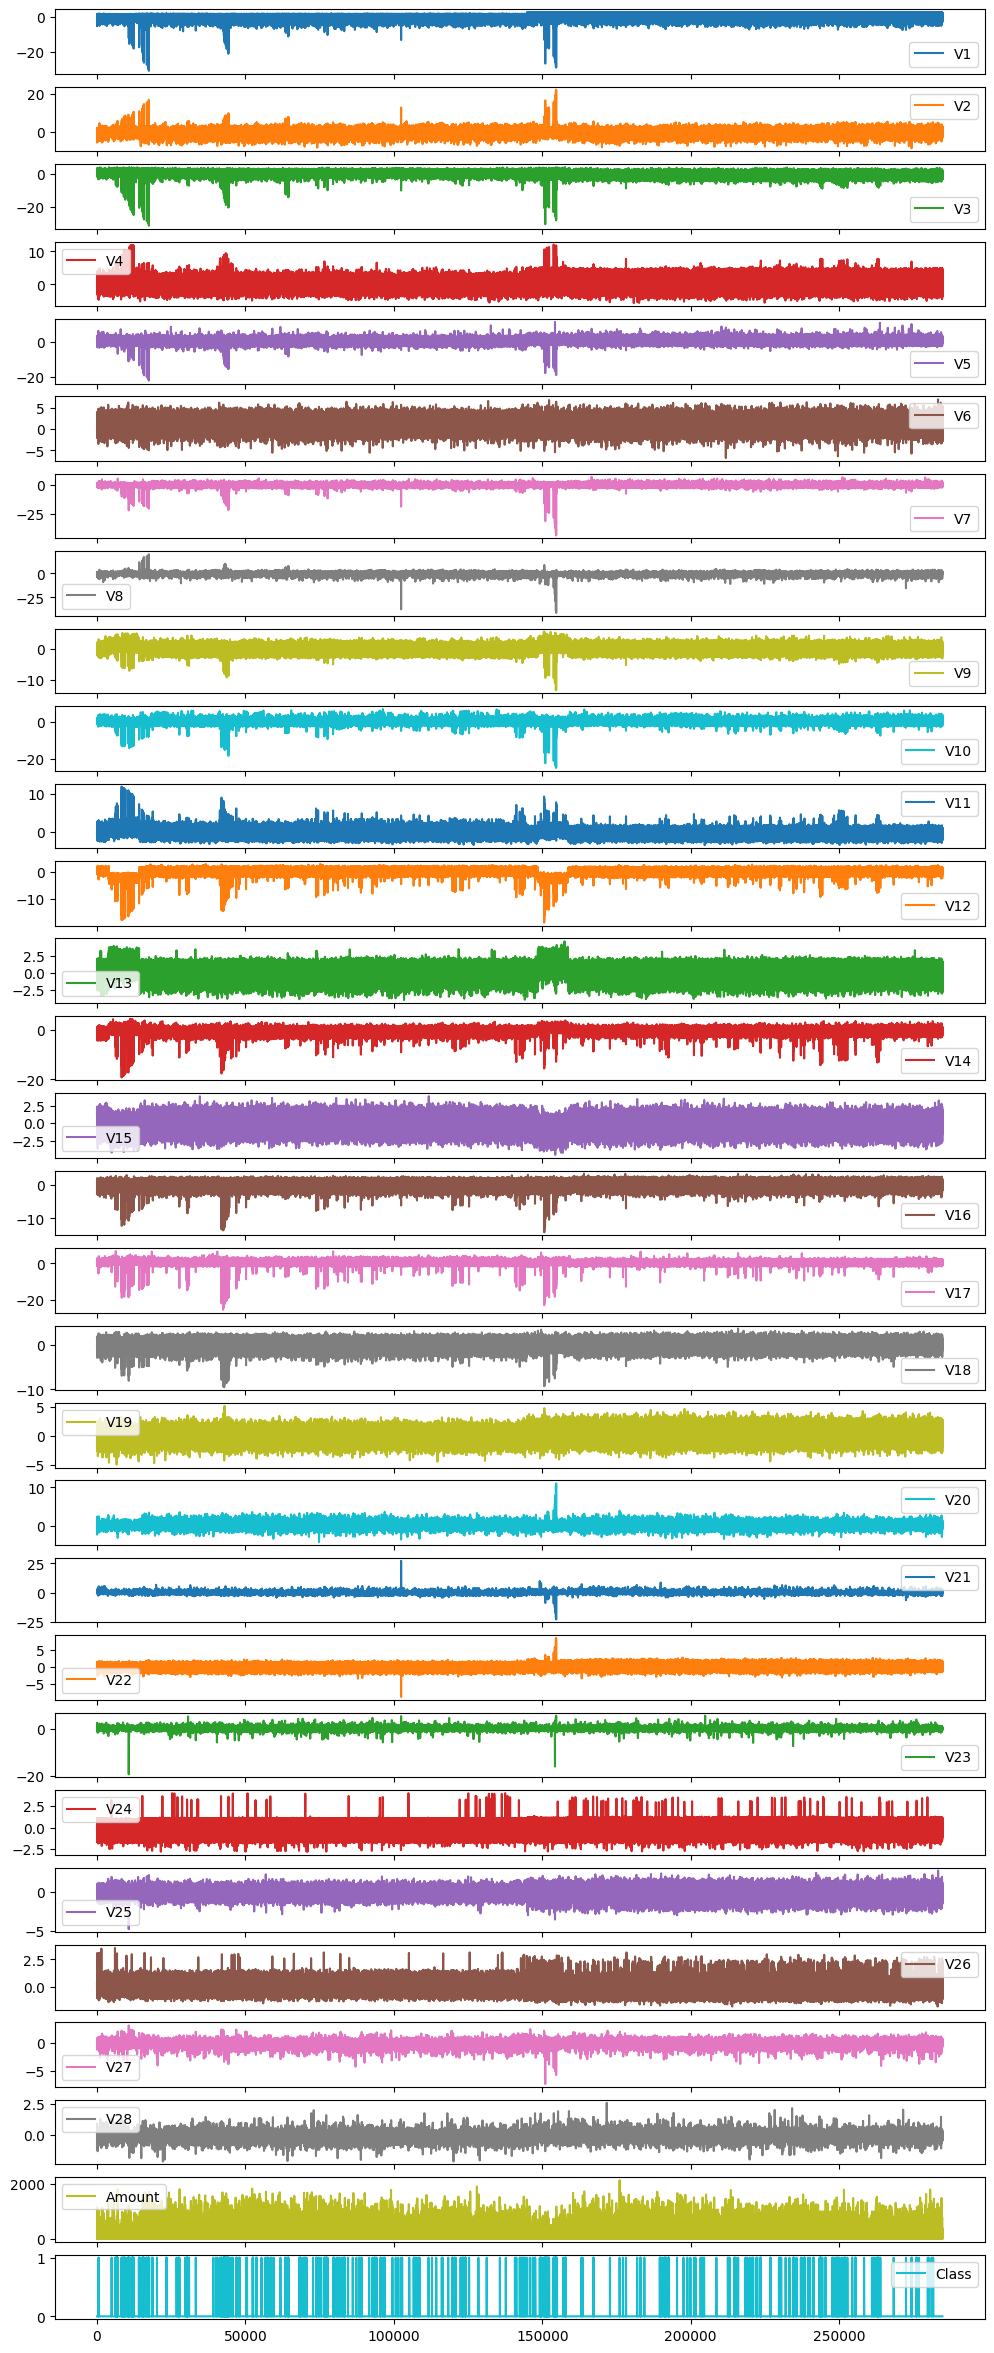

In [ ]:
df_cleaned = data.loc[(data['if_inliers']==1) | (data['Class'] == 1)].drop(columns=['if_inliers'])
df_cleaned.plot(subplots=True, figsize = (12, 30))

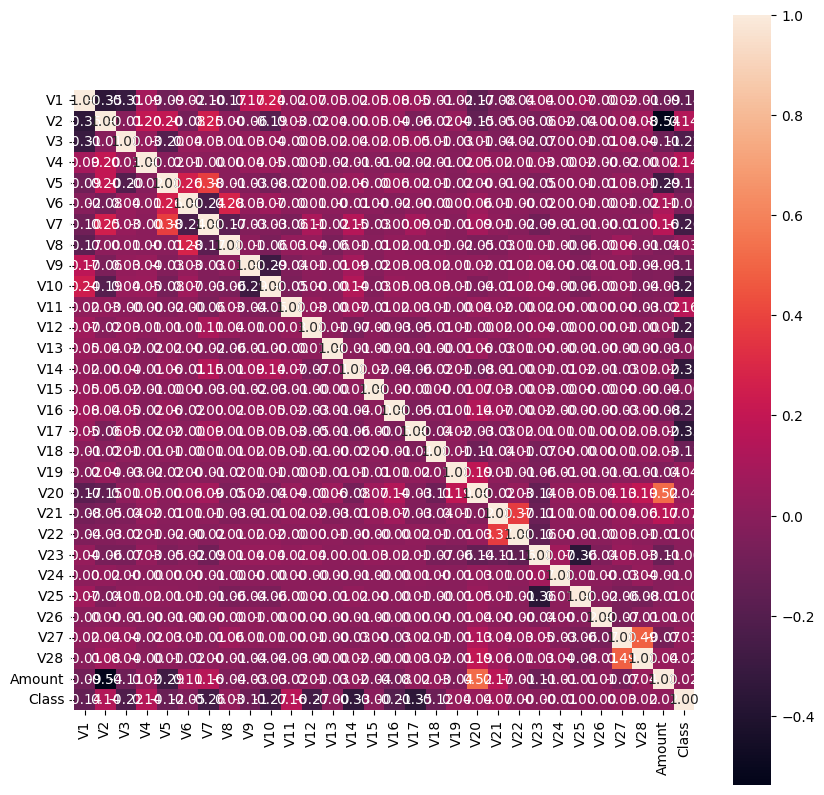

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(df_cleaned.corr(), fmt=".2f", annot=True, square=True)
plt.show()

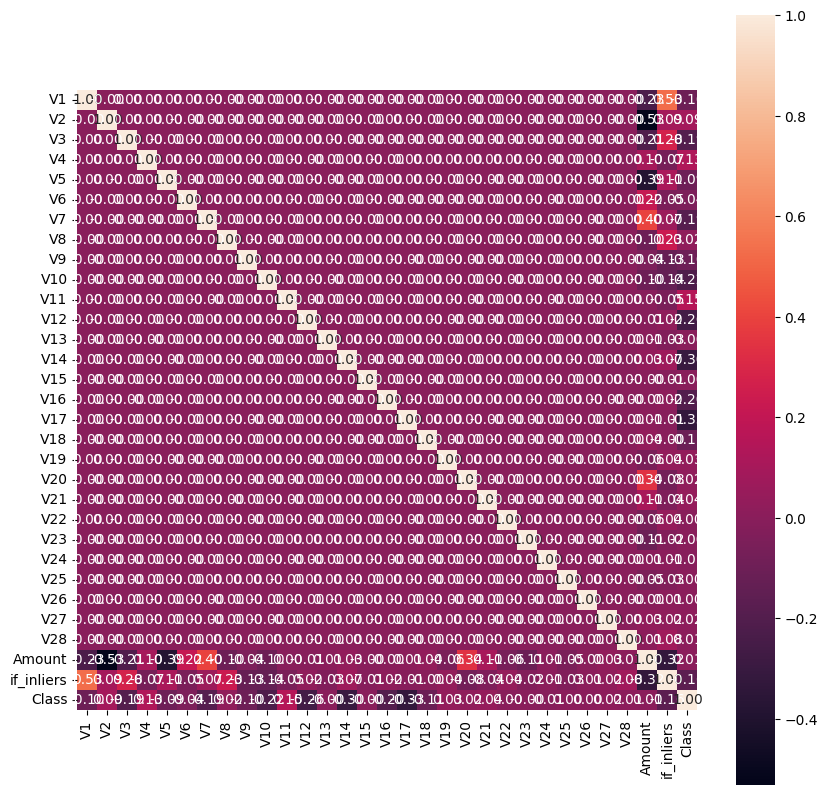

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), fmt=".2f", annot=True, square=True)
plt.show()

Особой разницы между корреляционными матрицами незаметно

In [ ]:
X = np.array(df_cleaned.copy().drop(columns=['Class']))
y = df_cleaned['Class'].values
X_scaled = StandardScaler().fit_transform(np.array(X, dtype='float'))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True)
print('train:', np.unique(y_train, return_counts=True))
print('test:', np.unique(y_test, return_counts=True))


train: (array([0., 1.], dtype=float32), array([218332,    366]))
test: (array([0., 1.], dtype=float32), array([54549,   126]))


Выборка сильно смещена в сторону номальных трансакций (класс 0), что логично с точки зрения здравого смысла, но неудобно для наших целей: обнаружения мошеннических (класс 1)

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print('наивная реализация')
print(classification_report(y_test, predictions))

наивная реализация
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54549
         1.0       0.99      0.87      0.92       126

    accuracy                           1.00     54675
   macro avg       1.00      0.93      0.96     54675
weighted avg       1.00      1.00      1.00     54675



Точность обнаружения класса 1 неожиданно велика

In [ ]:
clf = LogisticRegression(class_weight = 'balanced', max_iter=1000)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print('с учётом весов классов')
print(classification_report(y_test, predictions))

с учётом весов классов
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     54549
         1.0       0.08      0.95      0.14       126

    accuracy                           0.97     54675
   macro avg       0.54      0.96      0.56     54675
weighted avg       1.00      0.97      0.98     54675



Recall для искомого класса увеличился, но при таком precision, общее качество получается крайне низким.

Попробуем сбалансировать выборку, добавляя синтетические примеры различными способами:

In [ ]:
# X_train_d = dd.from_array(X_train)
# y_train_d = dd.from_array(y_train)

def check_oversampling(augm):
    start = time.perf_counter()
    # X_scaled = StandardScaler().fit_transform(X)
    # X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True)
    X_train_augm, y_train_augm = augm.fit_resample(np.array(X_train), np.array(y_train))
    # X_train_augm, y_train_augm = augm.fit_resample(X_train_d, y_train_d)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_augm, y_train_augm)
    predictions = clf.predict(X_test)
    print('оверсемплинг: ', type(augm).__name__, ':',  X_train_augm.shape)
    print(classification_report(y_test, predictions))
    print('рассчитано за', time.perf_counter() - start, 'c')


X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True)
# для ускорения работы используем распараллеленный на все ядра алгоритм
# поиска ближайших соседей заранее подогнанный для работы с нашими данными
nn = NearestNeighbors(n_jobs=-1)
nn.fit(X_train, y_train)
check_oversampling(ADASYN(n_neighbors=nn))
check_oversampling(SMOTE(k_neighbors=nn))
check_oversampling(BorderlineSMOTE(k_neighbors=nn))
check_oversampling(SVMSMOTE(k_neighbors=nn))
# пара алгоримов, сочетающих андерсемплинг с оверсэмплингом
check_oversampling(SMOTETomek(smote=SMOTE(k_neighbors=nn)))
check_oversampling(SMOTEENN(smote=SMOTE(k_neighbors=nn)))

оверсемплинг:  ADASYN : (436574, 29)
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     54592
         1.0       0.02      0.94      0.03        83

    accuracy                           0.91     54675
   macro avg       0.51      0.92      0.49     54675
weighted avg       1.00      0.91      0.95     54675

рассчитано за 9.111243211999863 c
оверсемплинг:  SMOTE : (436578, 29)
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     54592
         1.0       0.05      0.92      0.10        83

    accuracy                           0.97     54675
   macro avg       0.53      0.94      0.54     54675
weighted avg       1.00      0.97      0.99     54675

рассчитано за 6.463146644000517 c
оверсемплинг:  BorderlineSMOTE : (436578, 29)
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     54592
         1.0       0.12      0.89      0.21       

Представляется, что алгоритм SVMSMOTE лучше остальных подходит для данного случая, но BorderlineSMOTE отрабатывает гораздо быстрее.

Методы, комбинирующие андерсемплинг с оверсемплигном, к сожалению, не рассчитаны на работу с BorderlineSMOTE, поэтому результирующая точность совпадает с той, что дал простой SMOTE. Кроме того, эффективность андерсемплинга не впечатляет. Время их работы также слишком велико.

Попробуем добавить полиномиальные комбинации имеющихся параметров

In [ ]:
start = time.perf_counter()
augm = BorderlineSMOTE()
pf = PolynomialFeatures(include_bias=False)
X_poly = pf.fit_transform(X, y)
print('полиномиальные коэффициенты', time.perf_counter() - start, 'с')
X_scaled = StandardScaler().fit_transform(X_poly)
print('масштабирование', time.perf_counter() - start, 'с')
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True)
X_train_augm, y_train_augm = augm.fit_resample(X_train, y_train)
print('аугментация', time.perf_counter() - start, 'с')
print('размерность данных:', X_train_augm.shape)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_augm, y_train_augm)
print('обучение модели', time.perf_counter() - start, 'с')
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

полиномиальные коэффициенты 0.9371557979998215 с
масштабирование 2.8385035689998404 с
аугментация 8.694273082999871 с
размерность данных: (436596, 464)
обучение модели 176.49350063499992 с
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54583
         1.0       0.52      0.84      0.64        92

    accuracy                           1.00     54675
   macro avg       0.76      0.92      0.82     54675
weighted avg       1.00      1.00      1.00     54675



Точность повысилась, но время работы алгоритма увеличилось также. Впрочем, для 464-х колонок этого следовало ожидать.

Попробуем понизить размерность данных после добавления полиномиальных коэффициентов:

In [ ]:
start = time.perf_counter()
augm = BorderlineSMOTE()
pf = PolynomialFeatures(degree=2)
X_poly = pf.fit_transform(X, y)

print('полиномиальные коэффициенты', time.perf_counter() - start, 'с')
print('размерность данных:', X_poly.shape)

X_scaled = StandardScaler().fit_transform(X_poly)
print('масштабирование', time.perf_counter() - start, 'с')

projector = PCA(n_components=0.9, svd_solver='full')
X_projected = projector.fit_transform(X_scaled)
print('понижение размерности', time.perf_counter() - start, 'с')
print('размерность данных:', X_projected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size=0.2, shuffle=True)
X_train_augm, y_train_augm = augm.fit_resample(X_train, y_train)
print('аугментация', time.perf_counter() - start, 'с')
print('размерность данных:', X_train_augm.shape)

clf = LogisticRegression(penalty='elasticnet', max_iter=100, solver='saga', l1_ratio=0.5)
clf.fit(X_train_augm, y_train_augm)
print('обучение модели', time.perf_counter() - start, 'с')

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

полиномиальные коэффициенты 0.8948512009999376 с
размерность данных: (273373, 465)
масштабирование 2.7767832179999914 с
понижение размерности 20.708488320000015 с
размерность данных: (273373, 179)
аугментация 24.15502332999995 с
размерность данных: (436606, 179)
обучение модели 204.21602600099982 с
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     54578
         1.0       0.10      0.92      0.17        97

    accuracy                           0.98     54675
   macro avg       0.55      0.95      0.58     54675
weighted avg       1.00      0.98      0.99     54675



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Точность алгоритма сильно упала, в сочетании с увеличением времени работы это говорит о неверно подобранных параметрах.

Перебор параметров с помощью GridSearchCV занимает довольно много времени

In [ ]:
# %timeit
# parameters = {
#     'pf__degree': [1, 2, 3], # степени многочленов для перебора
#     'en__alpha': [0.001, 0.01, 0.02, 0.1, 0.5],
#     'en__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.9, 1]
# }
# parameters = {
#     'pf__degree': [1, 2], # степени многочленов для перебора
#     'en__alpha': [0.001, 0.01, 0.02, 0.1, 0.5],
#     'en__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.9, 1]
# }

# augm = BorderlineSMOTE()

# pipe = Pipeline(steps=[
#     ('pf', PolynomialFeatures(include_bias=False)),
#     ('ss', StandardScaler()),
#     ('en', LogisticRegression(penalty='elasticnet', max_iter=100, solver='saga', l1_ratio=0.5)),
#     ])
# X_scaled = StandardScaler().fit_transform(np.array(X, dtype='float'))
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
# X_train_augm, y_train_augm = augm.fit_resample(np.array(X_train), np.array(y_train))

# grid_search = GridSearchCV(pipe, parameters, scoring=make_scorer(fbeta_score, beta=2), cv=5, n_jobs=-1, verbose=3)
# grid_search = grid_search.fit(X_train_augm, y_train_augm)

# print('Лучшие прамметры:', grid_search.best_params_)
# print('Тестовый результат:', classification_report(y_test, grid_search.predict(X_test)))

Итого: лучший результат на представленных данных дала логистическая регрессия в сочетании с очисткой данных от выбросов.

Эксперименты с Dask, следы которых можно увидеть в ячейке с импортами, не дали прироста производительности, так как существующие алгоритмы и так используют все доступные ядра процессора. Но нужно заметить, что дашборд, предоставляемый Dask довольно удобен для оценки времени, которо нужно, чтобы алгоритм досчитал.